**Load Python libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns 
import plotly.express as px
from wordcloud import WordCloud
import re
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, log_loss, precision_score
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**Load the dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
hotel_review = pd.read_csv('/content/drive/My Drive/CS 271: Project/tripadvisor_hotel_reviews.csv')
hotel_review["Review"] = hotel_review["Review"].str.lower()
hotel_review["Review"] = hotel_review["Review"].str.replace('\d+', '')
hotel_review.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not * experience hotel monaco seatt...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


# New Section

**Check random reviews to get a good idea of the dataset**

In [ ]:
print(hotel_review["Review"][0])

nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay  parking night,  


In [ ]:
print(hotel_review["Review"][5])

love monaco staff husband stayed hotel crazy weekend attending memorial service best friend husband celebrating th wedding anniversary, talk mixed emotions, booked suite hotel monte carlos, loaned beautiful fan-tanned goldfish named joliet weekend visited dogs worked desk human companions, room decorated nicely couch used pillows, l'occitane bath amenities welcome sight, room quiet peaceful, wireless internet access wonderful server went morning leaving problems printing boarding passes, afternoon reception serves oenophile-satisfying wine australia scrumptious cookies, restaurant closed renovation stay finally ate food good drinks better, word caution restaurant larger person not sit booths wo n't fit, '  lbs husband ' . table smack-against stomach couple inches space mighty uncomfortable patron larger pregnant, bad design opinion place decorated funky welcoming way metal wood handblown glass light fixtures expect seattle capital glass art industry, definitely stay reason,  


**Review count in each category**

In [ ]:
X = hotel_review.groupby(by='Rating')['Review'].count()
print(X)

Rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: Review, dtype: int64


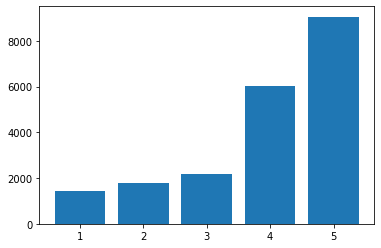

In [ ]:
p = plt.bar(X.index, X.values)

**Word count plot for each rating**

In [ ]:
# fig = px.histogram(hotel_review, x='Word Count', color='Rating',
#             barmode = 'overlay', nbins=50, marginal = 'box')
# fig.update_layout(title = "Word Count Distribution in Reviews by Ratings.",
#                  xaxis_title = "Word Count",
#                  yaxis_title = "No of Reviews")
# fig.show()

**Word Cloud**: To see a visual of most important words in the dataset

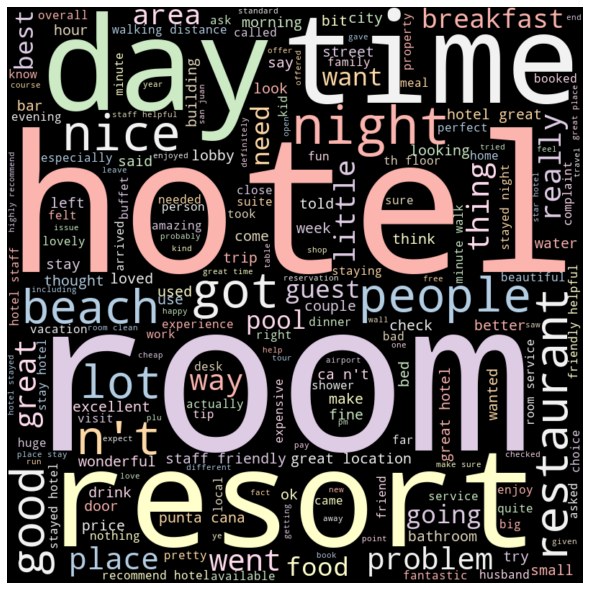

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, random_state=1,background_color='black', 
                      colormap='Pastel1').generate(" ".join(hotel_review["Review"]))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

**Bag of Words**

In [ ]:
count_vectorizer = CountVectorizer(max_features=500, analyzer='word', stop_words = 'english')
vector_model = count_vectorizer.fit_transform(hotel_review['Review']).toarray()
print(vector_model)
print(vector_model.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]]
(20491, 500)


In [ ]:
print("Top {} the most used word by reviewers: {}".format(500, count_vectorizer.get_feature_names()))

Top 1 the most used word by reviewers: ['able', 'absolutely', 'access', 'activities', 'actually', 'afternoon', 'air', 'airport', 'amazing', 'amenities', 'american', 'amsterdam', 'area', 'areas', 'arrival', 'arrived', 'ask', 'asked', 'ate', 'available', 'average', 'away', 'awesome', 'bad', 'bags', 'balcony', 'bar', 'barcelona', 'bars', 'bath', 'bathroom', 'bathrooms', 'beach', 'beautiful', 'bed', 'bedroom', 'beds', 'beer', 'believe', 'best', 'better', 'big', 'bit', 'block', 'blocks', 'book', 'booked', 'booking', 'bottle', 'breakfast', 'bring', 'brought', 'buffet', 'building', 'bus', 'business', 'busy', 'buy', 'ca', 'cafe', 'called', 'came', 'cana', 'car', 'card', 'care', 'casino', 'center', 'central', 'centre', 'certainly', 'chairs', 'change', 'charge', 'cheap', 'check', 'checked', 'children', 'choice', 'choose', 'chose', 'city', 'clean', 'cleaned', 'close', 'club', 'coffee', 'cold', 'come', 'comfortable', 'coming', 'complaint', 'complimentary', 'concierge', 'convenient', 'cool', 'corne

**Extracting words**

In [ ]:
data=pd.DataFrame(count_vectorizer.get_feature_names(),columns=["Words"])
data.head()

,Words
0,able
1,absolutely
2,access
3,activities
4,actually


**Wordclould after extractiong most meaningful words**

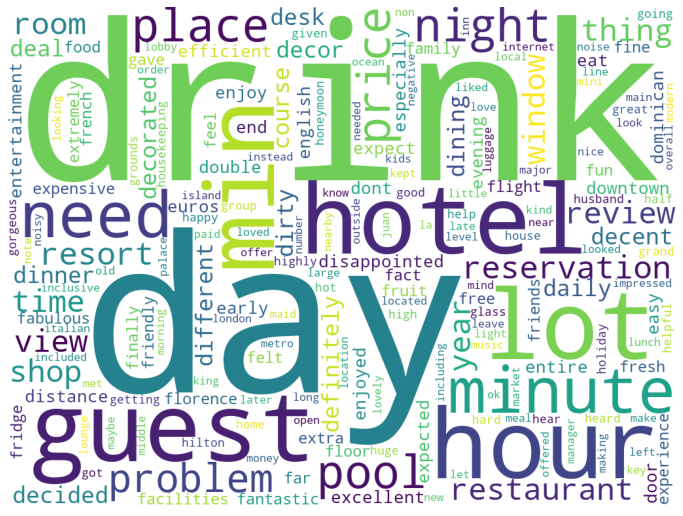

In [ ]:
plt.subplots(figsize=(12,12))
wordcloud=WordCloud(background_color="white",width=1024,height=768).generate(" ".join(data.Words[100:]))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Split training and testing sets**

In [ ]:
from imblearn.over_sampling import SMOTE 
X = vector_model
y = hotel_review['Rating']

sm = SMOTE(random_state = 2) 
X_smote, y_smote = sm.fit_sample(X, y) 

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 2)
print(y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



[1 4 3 ... 1 2 1]


# **Building ML models**

**SVM**

In [ ]:
from sklearn.svm import SVC
no_of_features = 5
svclassifier = SVC(kernel= 'rbf', gamma = 'auto', verbose = True, random_state=42 )
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

[LibSVM]

In [ ]:
print(f'Confusion Matrix \n {confusion_matrix(y_test, y_pred)}')
print("Accuracy with P-R scores and F-score")
print(classification_report(y_test, y_pred))
print()

Confusion Matrix 
 [[1550  186   57    5    9]
 [ 783  656  298   55   43]
 [ 326  298  903  245   39]
 [  94  106  356  843  396]
 [  46   42   44  416 1258]]
Accuracy with P-R scores and F-score
              precision    recall  f1-score   support

           1       0.55      0.86      0.67      1807
           2       0.51      0.36      0.42      1835
           3       0.54      0.50      0.52      1811
           4       0.54      0.47      0.50      1795
           5       0.72      0.70      0.71      1806

    accuracy                           0.58      9054
   macro avg       0.57      0.58      0.56      9054
weighted avg       0.57      0.58      0.56      9054




**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier


rf_model=RandomForestClassifier(random_state=42)
rf_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
y_pred=rf_model.predict(X_test)

In [ ]:
print(f'Confusion Matrix \n {confusion_matrix(y_test, y_pred)}')
print("Accuracy with P-R scores and F-score")
print(classification_report(y_test, y_pred))
print()

Confusion Matrix 
 [[1623   87   51   30   16]
 [ 119 1416  120  105   75]
 [  60   90 1378  191   92]
 [  24   61  157  995  558]
 [  17   25   26  387 1351]]
Accuracy with P-R scores and F-score
              precision    recall  f1-score   support

           1       0.88      0.90      0.89      1807
           2       0.84      0.77      0.81      1835
           3       0.80      0.76      0.78      1811
           4       0.58      0.55      0.57      1795
           5       0.65      0.75      0.69      1806

    accuracy                           0.75      9054
   macro avg       0.75      0.75      0.75      9054
weighted avg       0.75      0.75      0.75      9054




**LSTM**

In [ ]:
X = vector_model
y = hotel_review['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 1)
print(X_test)

[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import SpatialDropout1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional


model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=20491,
                    output_dim=500,
                    input_length=500))


model.add(LSTM(100))
model.add(Dense(500, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 500)          10245500  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               240400    
_________________________________________________________________
dense (Dense)                (None, 500)               50500     
Total params: 10,536,400
Trainable params: 10,536,400
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data= (X_test, y_test), shuffle= False)

Epoch 1/10
1132/1132 [==============================] - 1620s 1s/step - loss: 1.4309 - accuracy: 0.3429 - val_loss: 1.4392 - val_accuracy: 0.3057
Epoch 2/10
1132/1132 [==============================] - 1622s 1s/step - loss: 1.4282 - accuracy: 0.3445 - val_loss: 1.4385 - val_accuracy: 0.3087
Epoch 3/10
1132/1132 [==============================] - 1618s 1s/step - loss: 1.4241 - accuracy: 0.3458 - val_loss: 1.4356 - val_accuracy: 0.3102
Epoch 4/10
1132/1132 [==============================] - 1641s 1s/step - loss: 1.4199 - accuracy: 0.3494 - val_loss: 1.4297 - val_accuracy: 0.3171
Epoch 5/10
1132/1132 [==============================] - 1667s 1s/step - loss: 1.4145 - accuracy: 0.3562 - val_loss: 1.4219 - val_accuracy: 0.3257
Epoch 6/10
1132/1132 [==============================] - 1631s 1s/step - loss: 1.4089 - accuracy: 0.3612 - val_loss: 1.4198 - val_accuracy: 0.3317
Epoch 7/10
1132/1132 [==============================] - 1694s 1s/step - loss: 1.4039 - accuracy: 0.3664 - val_loss: 1.4169 -

**Plotting training progression**

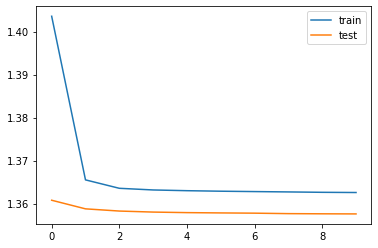

In [ ]:
plt.plot(history_lstm.history['loss'], label = 'train')
plt.plot(history_lstm.history['val_loss'], label = 'test')
plt.legend()
plt.show()

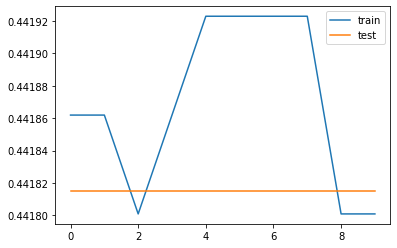

In [ ]:
plt.plot(history_lstm.history['accuracy'], label = 'train')
plt.plot(history_lstm.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()